In [ ]:
#!python eval_on_dataset.py -m "lmsys/vicuna-7b-v1.3" -d "updated_examples.csv"

In [1]:
!pip install transformers

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [76]:
#df = pd.read_csv("examples.csv")
df = pd.read_csv("updated_examples.csv")

In [77]:
df

,sentence,question,set_id,type,answer,correct_option,incorrect_option
0,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,child
1,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,guest
2,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the guest scare?,1,second_center_mid,The neighbor,neighbor,child
3,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,guest
4,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the guest scare?,1,second_center_sim,The neighbor,neighbor,child
5,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,1,first_center_sim,The child,child,guest
6,"The child, who was liked by the neighbor, fell. The neighbor is the one scared by the guest.",Who did the guest scare?,1,second_center_sim_rev,The neighbor,neighbor,child
7,"The child, who was liked by the neighbor, fell. The neighbor is the one scared by the guest.",Who did the neighbor like?,1,first_center_sim_rev,The child,child,guest
8,The man that the investigator that the journalist admired checked laughed.,Who did the journalist admire?,2,second_center_com,The investigator,investigator,man
9,The man that the investigator that the journalist admired checked laughed.,Who did the investigator check?,2,first_center_com,The man,man,journalist


In [5]:
MODEL_NAME = "lmsys/vicuna-7b-v1.3"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [6]:
def generate_prompt(sentence, question):
    prompt = (
    f"Sentence: The capital of France is one of the most visited cities in the world.\n"
    f"Question: What is the capital of France?\n"
    f"Answer: Paris\n\n"
    f"Sentence: Water is composed of two hydrogen atoms and one oxygen atom.\n"
    f"Question: What is the chemical symbol for water?\n"
    f"Answer: H₂O\n\n"
    f"Sentence: The Earth is divided into large landmasses known as continents.\n"
    f"Question: How many continents are there on Earth?\n"
    f"Answer: Seven\n"
    f"Sentence: {sentence}\n"
    f"Question: {question}\n"
    f"Answer: The")

    return prompt

In [79]:
def predict_answer(model, tokenizer, sentence, correct_option, incorrect_option, question, num_tokens=5):
    prompt = generate_prompt(sentence, question)
    input_ids_sentence = tokenizer(prompt, return_tensors="pt").input_ids.to(DEVICE)
    correct_tokens = tokenizer(correct_option, return_tensors="pt").input_ids.squeeze()
    incorrect_tokens = tokenizer(incorrect_option, return_tensors="pt").input_ids.squeeze()

    # Get the possible token IDs (correct and incorrect tokens)
    correct_token_ids = correct_tokens.tolist()
    incorrect_token_ids = incorrect_tokens.tolist()
    valid_token_ids = list(set(correct_token_ids + incorrect_token_ids))
    if tokenizer.bos_token_id is not None:
      valid_token_ids.remove(tokenizer.bos_token_id)

    # Initialize the predicted tokens list with the sentence input
    generated_ids = input_ids_sentence
    answer_ids = tokenizer.encode("The")
    is_first_diff_token = False


    # here we are generting sequence in num_tokens length, to handle multiple tokens answers
    # in the accuracy calculation we will ceck only the first token of the answer
    for it in range(num_tokens):
        if len(correct_token_ids) > it and len(incorrect_token_ids) > it and correct_token_ids[it] == incorrect_token_ids[it]:
          if correct_token_ids[it] != tokenizer.bos_token_id:
            generated_ids = torch.cat((generated_ids, torch.tensor([[correct_token_ids[it]]], device=generated_ids.device)), dim=-1)
            answer_ids.append(correct_token_ids[it])
          continue

        with torch.no_grad():
            outputs = model(generated_ids)
            logits = outputs.logits

        next_token_logits = logits[:, -1, :]
        next_token_logits_valid = next_token_logits[:, valid_token_ids]

        # Extract logits only for the tokens in correct and incorrect options and calc the probabilities
        if not is_first_diff_token:
          is_first_diff_token = True
          correct_first_token = correct_token_ids[it]
          incorrect_first_token = incorrect_token_ids[it]
          probabilities_token_ids = [correct_first_token,incorrect_first_token]
          probabilities_logits = next_token_logits[:,probabilities_token_ids]
          # calculate probabilities over first different tokens
          probabilities = torch.softmax(probabilities_logits, dim=-1)
          probabilities_list = probabilities.squeeze().tolist()
          token_probabilities = {token_id: prob for token_id, prob in zip(probabilities_token_ids, probabilities_list)}

        # Find the argmax of the valid token logits
        predicted_token_id = valid_token_ids[torch.argmax(next_token_logits_valid)]

        predicted_token_id_tensor = torch.tensor([[predicted_token_id]], device=generated_ids.device)
        answer_ids.append(predicted_token_id)
        generated_ids = torch.cat((generated_ids, predicted_token_id_tensor), dim=-1)

    predicted_text = tokenizer.decode(answer_ids, skip_special_tokens=True)
    return predicted_text, token_probabilities, correct_first_token, incorrect_first_token

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token_id is None:
   tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16)
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      

### Predict and calculate accuracy

In [166]:
def predict_and_calculate_correct_predictions(model, tokenizer, data_df,
                                              output_path='output.csv', should_print=False):
    correct_predictions = 0
    total_predictions = 0

    output = []

    for index, row in data_df.iterrows():
        sentence = row['sentence']
        correct_option = row['correct_option']
        incorrect_option = row['incorrect_option']
        true_answer = row['answer']
        question = row['question']

        predicted_answer, token_probabilities, correct_token, incorrect_token = \
          predict_answer(model, tokenizer, sentence, correct_option, incorrect_option, question)
        if should_print:
          print(f"Sentence: {sentence}")
          print(f"Correct Option: {correct_option}")
          print(f"Incorrect Option: {incorrect_option}")
          print(f"True Answer: {true_answer}")
          print(f"Predicted Answer: {predicted_answer}")

        is_correct_prediction = predicted_answer.startswith(true_answer)
        if is_correct_prediction:
            correct_predictions += 1
            if print:
              print("Correct prediction!")
        else:
            if print:
              print("Incorrect prediction.")

        if print:
          print("-" * 50)

        total_predictions += 1


        output.append({
            # Add all columns from original df, and some additional information
            'sentence': row['sentence'],
            'question': row['question'],
            'set_id': row['set_id'],
            'type': row['type'],
            'answer': row['answer'],
            'correct_option': correct_option,
            'correct_first_token': correct_token,
            'correct_probability': token_probabilities.get(correct_token, 0),
            'incorrect_option': incorrect_option,
            'incorrect_first_token': incorrect_token,
            'incorrect_probability': token_probabilities.get(incorrect_token, 0),
            'predicted_answer': predicted_answer,
            'is_correct_prediction': is_correct_prediction
        })

    output_df = pd.DataFrame(output)
    output_df.to_csv(output_path, index=False)

    return correct_predictions, total_predictions

def calc_accuracy(correct_predictions, total_predictions, print=False):
    accuracy = correct_predictions / total_predictions * 100
    if print:
      print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

### Running model to get predictions

In [134]:
# Relevant variables
res_dir = MODEL_NAME.replace("/", "_")
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
data_path = "updated_examples.csv"
# Path for saving model predictions
out_path = os.path.join(res_dir, "examples_with_predictions.csv")

In [135]:
def run(data_path, out_path):
  df = pd.read_csv(data_path)
  correct_predictions_all, total_predictions_all = predict_and_calculate_correct_predictions(model, tokenizer, df, output_path=out_path)
  # Run on only a part of the df
  #df_first = df[df["type"] == "first_center_sim"]
  #correct_predictions_first, total_predictions_first = predict_and_calculate_correct_predictions(model, tokenizer, df_first, output_path='first_center_output.csv')
  #print(correct_predictions_first)
  #print(total_predictions_first)
  return correct_predictions_all, total_predictions_all

In [136]:
correct_predictions_all, total_predictions_all = run(data_path, out_path)

Incorrect prediction.
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Incorrect prediction.
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Correct prediction!
--------------------------------------------------
Co

### Seperate to datarames according to type and wording

In [137]:
# df = pd.read_csv("examples_with_predictions.csv"). #out_path)
df = pd.read_csv("/content/lmsys_vicuna-7b-v1.3/examples_with_predictions.csv")

In [138]:
df.head()

,sentence,question,set_id,type,answer,correct_option,correct_first_token,correct_probability,incorrect_option,incorrect_first_token,incorrect_probability,predicted_answer,is_correct_prediction
0,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,12307,0.247987,child,2278,0.752013,The child neighbor child child,False
1,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,2278,0.968381,guest,17838,0.031619,The child guest child guest,True
2,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the guest scare?,1,second_center_mid,The neighbor,neighbor,12307,0.317426,child,2278,0.682574,The child child child child,False
3,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,2278,0.997449,guest,17838,0.002551,The child child child child,True
4,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the guest scare?,1,second_center_sim,The neighbor,neighbor,12307,0.577495,child,2278,0.422505,The neighbor child neighbor child,True


In [139]:
correct_preds_dict={}
total_preds_dict={}

for sen_type in df["type"].unique():
  sen_type_df= df[df["type"] == sen_type]
  correct_predictions= len(sen_type_df[sen_type_df["is_correct_prediction"]==1])
  correct_preds_dict[sen_type]= correct_predictions
  total_predictions= len(sen_type_df)
  total_preds_dict[sen_type]= total_predictions


In [140]:
# Sanity check
print(sum(correct_preds_dict.values()) == correct_predictions_all)
print(sum(total_preds_dict.values()) == total_predictions_all)

True
True


### Plot functions

In [141]:
def plot_acc(acc_dict, title, xlabels, res_dir):
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(8, 6))

  # Create the barplot
  bars = ax.bar(list(acc_dict.keys()), list(acc_dict.values()), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], edgecolor='black', alpha=0.85)

  # Add the accuracy values on top of the bars
  for bar in bars:
      height = bar.get_height()
      ax.annotate(f'{height:.2f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),  # Place the text at the top of the bar
                  xytext=(0, 3),  # Slightly above the bar
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

  # Set the title and labels
  ax.set_title(title, fontsize=16, fontweight='bold')
  ax.set_xlabel(xlabels, fontsize=14)
  ax.set_ylabel('Accuracy', fontsize=14)

  # Improve layout and aesthetics
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_color('#4c4c4c')
  ax.spines['bottom'].set_color('#4c4c4c')
  ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.7)

  plt.tight_layout()

  # Save the plot
  filename = title.lower().replace(' ', '_') + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show the plot
  plt.show()

In [142]:
def plot_grouped_barplot(categories, group_values, group_labels, xlabel, title, res_dir):
    """
    Function to create a grouped bar plot for categories with multiple groups of values.

    Parameters:
    - categories: A list of categories (e.g., different items, labels, etc.).
    - group_values: A list of lists, where each sublist contains values for a specific group.
                    Each sublist should correspond to a single group across all categories.
    - group_labels: A list of labels corresponding to each group.

    Example:
    plot_grouped_barplot(['Category 1', 'Category 2'], [[1.97, 0.61], [0.61, 0.51]], ['Group 1', 'Group 2'])
    """

    # Number of categories and number of groups
    n_categories = len(categories)
    n_groups = len(group_values)

    # Make sure the number of group values matches the number of labels
    assert n_groups == len(group_labels), "The number of group value sets must match the number of group labels"

    # Create bar width and position for grouped bars
    bar_width = 0.8 / n_groups  # Adjust bar width based on the number of groups
    index = np.arange(n_categories)

    # Plotting
    fig, ax = plt.subplots()

    # Loop through each group and plot its bars
    bars = []
    for i in range(n_groups):
        bars.append(ax.bar(index + i * bar_width, group_values[i], bar_width, label=group_labels[i]))

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(index + bar_width * (n_groups - 1) / 2)
    ax.set_xticklabels(categories)

    # Increase y-axis limit for better spacing
    max_value = max([max(group) for group in group_values])
    ax.set_ylim(0, max_value * 1.4)  # Set y-limit a bit higher than the maximum value to allow space for labels

    # Add legend
    ax.legend()

    # Optionally add values above bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    for bar_group in bars:
        add_labels(bar_group)

    # Display the plot
    plt.tight_layout()

    # Save the plot
    filename = title.lower().replace(' ', '_') + '.png'
    file_path = os.path.join(res_dir, filename)
    plt.savefig(file_path)

    # Show the plot after saving
    plt.show()


### Plots

In [143]:
wordings = ["com", "mid", "sim", "sim_rev"]
all_center_types = ["first_center", "second_center"]

# Calculate accuracy for each wording separately
wording_accuracy = {}

for wording in wordings:
  correct_predictions = 0
  total_predictions = 0
  for center_type in all_center_types:
    correct_predictions += correct_preds_dict[center_type + "_" + wording]
    total_predictions += total_preds_dict[center_type + "_" + wording]
  wording_accuracy[wording] = calc_accuracy(correct_predictions, total_predictions)

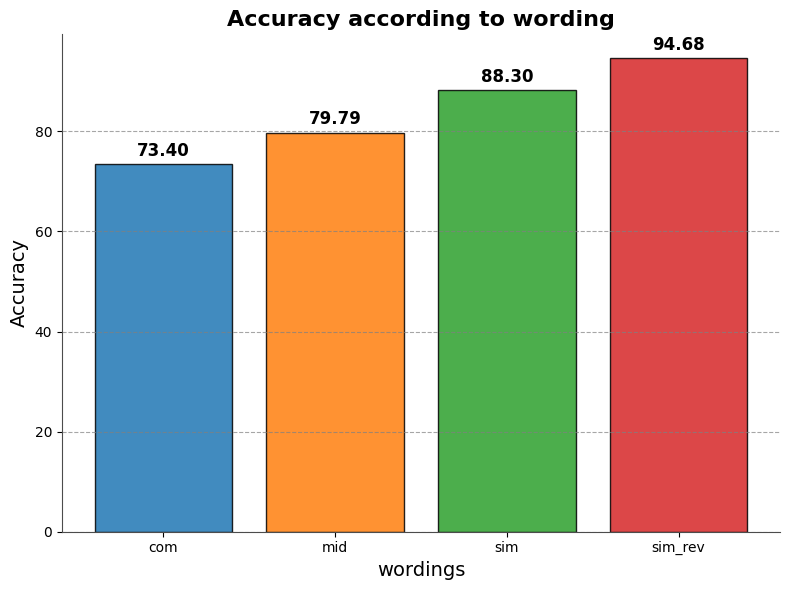

In [144]:
plot_acc(wording_accuracy, "Accuracy according to wording", "wordings", res_dir)

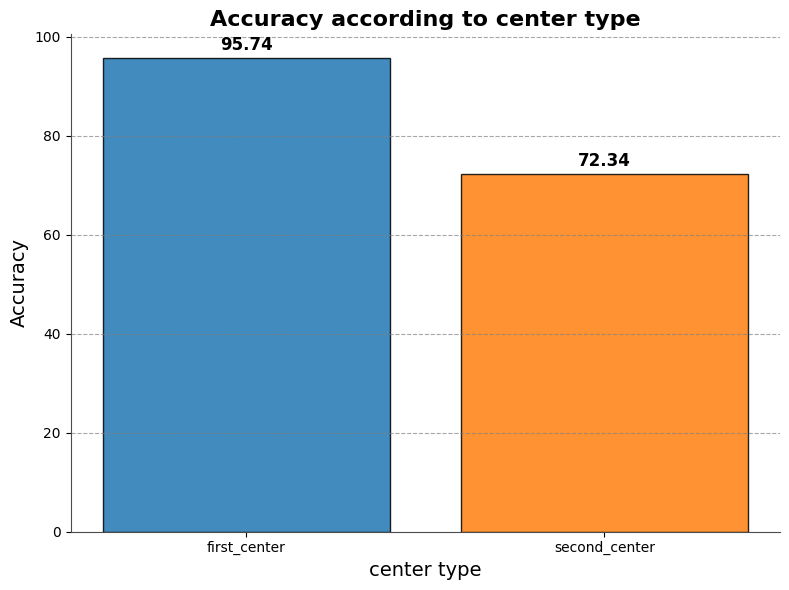

In [145]:
# Compare according to different types
center_types_accuracy = {}

for center_type in all_center_types:
  correct_predictions = 0
  total_predictions = 0
  for wording in wordings:
    correct_predictions += correct_preds_dict[center_type + "_" + wording]
    total_predictions += total_preds_dict[center_type + "_" + wording]
  center_types_accuracy[center_type] = calc_accuracy(correct_predictions, total_predictions)

plot_acc(center_types_accuracy, "Accuracy according to center type", "center type", res_dir)

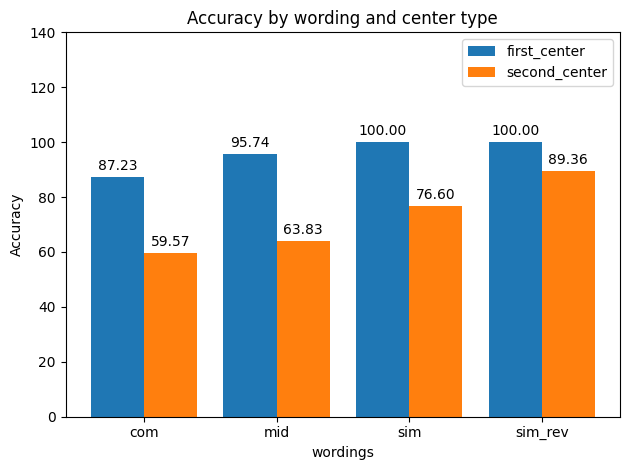

In [146]:
# Draw a plot of accuracy by wording category and center type as group

acc_by_wording_center_type = []

for center_type in all_center_types:
  wording_acc = []
  for wording in wordings:
    correct_predictions = correct_preds_dict[center_type + "_" + wording]
    total_predictions = total_preds_dict[center_type + "_" + wording]
    wording_acc.append(calc_accuracy(correct_predictions, total_predictions))
  acc_by_wording_center_type.append(wording_acc)

plot_grouped_barplot(wordings, acc_by_wording_center_type, all_center_types, "wordings", "Accuracy by wording and center type", res_dir)

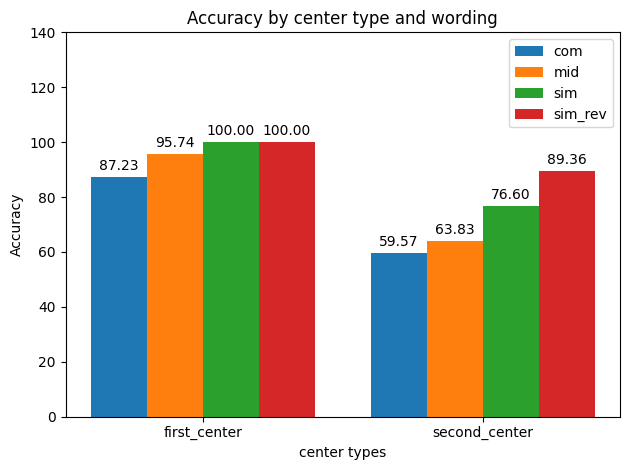

In [147]:
# Draw a plot of accuracy by center type as category and wording as group

acc_by_center_type_wording = []

for wording in wordings:
  center_type_acc = []
  for center_type in all_center_types:
    correct_predictions = correct_preds_dict[center_type + "_" + wording]
    total_predictions = total_preds_dict[center_type + "_" + wording]
    center_type_acc.append(calc_accuracy(correct_predictions, total_predictions))
  acc_by_center_type_wording.append(center_type_acc)

plot_grouped_barplot(all_center_types, acc_by_center_type_wording, wordings, "center types", "Accuracy by center type and wording", res_dir)

In [148]:
def plot_confidence(confidence, res_dir, title, color="blue"):
  plt.figure(figsize=(10, 6))

  # Plot histogram for first list
  sns.histplot(confidence , bins=20, kde=False, color=color, alpha=0.5, label='right', stat="density")

  # Add labels and title
  plt.title(title)
  plt.xlabel('Probability')
  plt.ylabel('Density')

  # Save the plot
  filename = title.lower().replace(' ', '_') + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)
  # Show the plot
  plt.show()

In [ ]:
lue

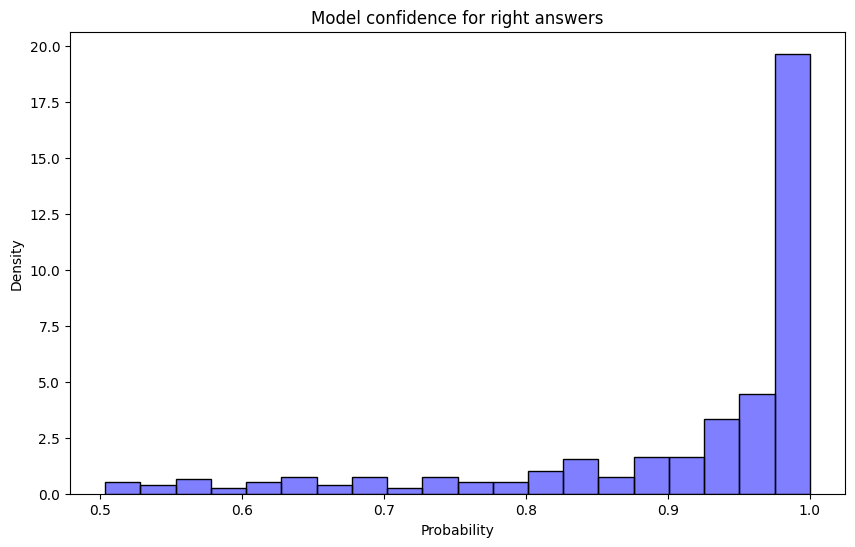

In [149]:
# Check model confidence for right answers
right = df[(df["is_correct_prediction"] == True)]
plot_confidence(right["correct_probability"], res_dir, title='Model confidence for right answers')

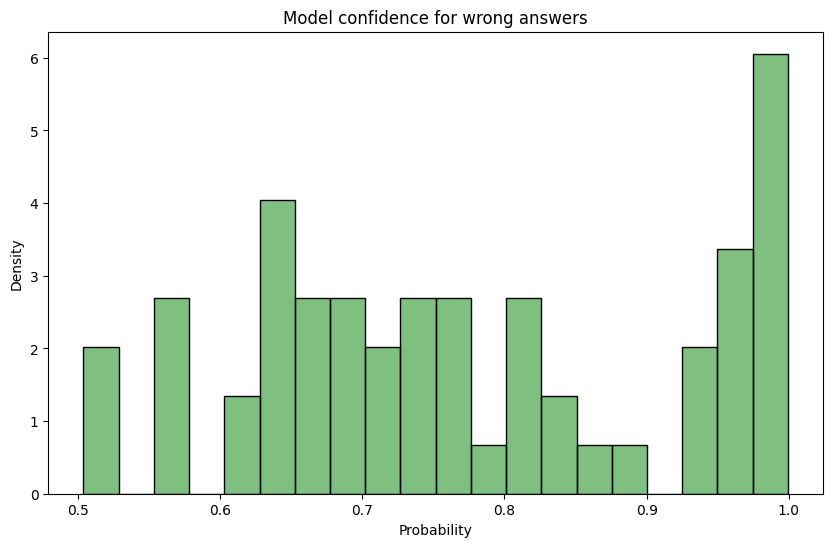

In [150]:
# Check model confidence for wrong answers
wrong = df[(df["is_correct_prediction"] == False)]
plot_confidence(wrong["incorrect_probability"], res_dir, title='Model confidence for wrong answers', color="green")

### Explore probabilities

In [151]:
# Take all second sim type where the model was wrong
wrong_second_sim = df[(df["type"] == "second_center_sim") & (df["is_correct_prediction"] == False)]
wrong_second_sim.head(10)

,sentence,question,set_id,type,answer,correct_option,correct_first_token,correct_probability,incorrect_option,incorrect_first_token,incorrect_probability,predicted_answer,is_correct_prediction
20,"There is that mover known by the architect, so the thief, who was surprised by the mover, got caught.",Who did the architect know?,3,second_center_sim,The mover,mover,286,0.355775,thief,266,0.644225,The thief mover,False
28,"There is that producer hired by the director, so the student, who was preferred by the producer, resigned.",Who did the director hire?,4,second_center_sim,The producer,producer,14297,0.304042,student,8368,0.695958,The student producer student producer,False
68,"There is that curator hired by the museum, so the artist, who was praised by the curator, smiled.",Who did the museum hire?,10,second_center_sim,The curator,curator,3151,0.331120,artist,7664,0.668880,The artist curator artist,False
76,"There is that librarian met by the author, so the child, which was liked by the librarian, smiled.",Who did the author meet?,11,second_center_sim,The librarian,librarian,619,0.362969,child,2278,0.637031,The child librarian,False
124,"There is that principal blamed by the parent, so the teacher, who was scolded by the principal, resigned.",Who did the parent blame?,17,second_center_sim,The principal,principal,5882,0.194368,teacher,15703,0.805632,The teacher principal principal teacher,False
180,"There is that conductor cheered by the audience, so the musician, who was liked by the conductor, performed.",Who did the audience cheer?,24,second_center_sim,The conductor,conductor,7512,0.030215,musician,4696,0.969785,The musician conductor,False
204,"There is that coach praised by the reporter, so the athlete, who was hated by the coach, won.",Who did the reporter praise?,27,second_center_sim,The coach,coach,11182,0.430147,athlete,17622,0.569853,The athlete coach ath,False
220,"There is that coach adored by the fan, so the player, who was shouted at by the coach, scored a goal.",Who did the fan adore?,29,second_center_sim,The coach,coach,11182,0.002397,player,4847,0.997603,The player coach player coach,False
236,"There is that architect hired by the client, so the engineer, who was hated by the architect, designed the building.",Who did the client hire?,31,second_center_sim,The architect,architect,6956,0.245085,engineer,22055,0.754915,The engineer architect architect engineer,False
252,"There is that choreographer applauded by the audience, so the dancer, who was loved by the choreographer, performed.",Who did the audience applaud?,33,second_center_sim,The choreographer,choreographer,521,0.355775,dancer,6025,0.644225,The dancer dancer,False


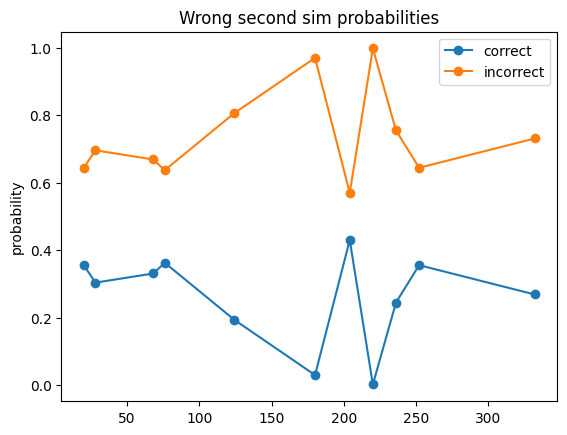

In [152]:
# Plot the probabilities for correct and incorrect answers
title = "Wrong second sim probabilities"
plt.title(title)
plt.ylabel("probability")
plt.plot(wrong_second_sim["correct_probability"], marker='o', label="correct")
plt.plot(wrong_second_sim["incorrect_probability"], marker='o', label="incorrect")
plt.legend()
# Save the plot
filename = title.lower().replace(' ', '_') + '.png'
plt.savefig(filename)

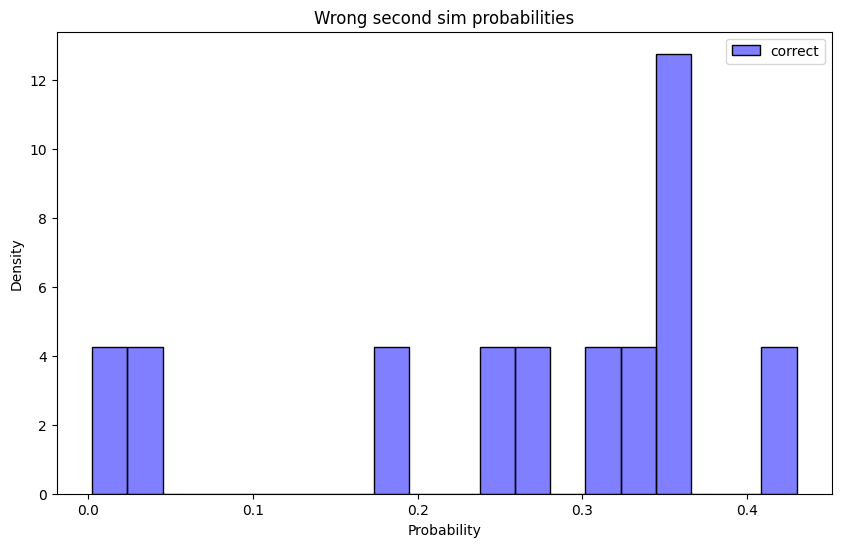

In [153]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for first list
sns.histplot(wrong_second_sim["correct_probability"], bins=20, kde=False, color='blue', alpha=0.5, label='correct', stat="density")

# Plot histogram for second list
# sns.histplot(wrong_second_sim["incorrect_probability"], bins=20, kde=False, color='green', alpha=0.5, label='incorrect')

# Add labels and title
plt.title('Wrong second sim probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

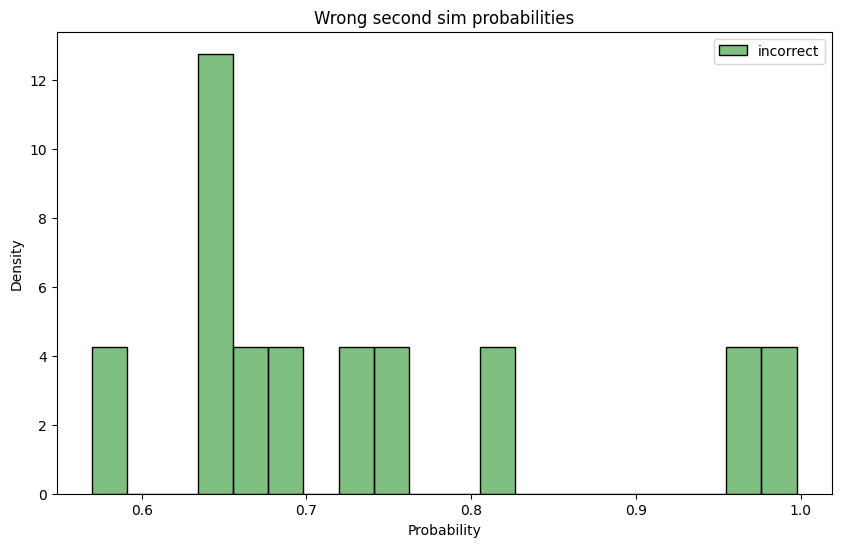

In [154]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for first list
# sns.histplot(wrong_second_sim["correct_probability"], bins=20, kde=False, color='blue', alpha=0.5, label='correct')

# Plot histogram for second list
sns.histplot(wrong_second_sim["incorrect_probability"], bins=20, kde=False, color='green', alpha=0.5, label='incorrect', stat="density")

# Add labels and title
plt.title('Wrong second sim probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [155]:
def plot_confidence(df, type, res_dir):
  # For wrong answers
  plt.figure(figsize=(10, 6))
  wrong = df[(df["is_correct_prediction"] == False)]
  sns.histplot(wrong["incorrect_probability"], bins=20, kde=False, color='green', alpha=0.5, label='incorrect', stat="density")

  # Add labels and title
  title = f'Confidence wrong {type}'
  plt.title(title)
  plt.xlabel('Probability')
  plt.ylabel('Density')
  plt.legend()
  # Save the plot
  filename = title.lower().replace(' ', '_') + '.png'
  plt.savefig(filename)
  # Show the plot
  plt.show()

  # For correct answers
  plt.figure(figsize=(10, 6))
  right = df[(df["is_correct_prediction"] == True)]
  sns.histplot(right["correct_probability"], bins=20, kde=False, color='green', alpha=0.5, label='correct', stat="density")

  # Add labels and title
  title = f'Confidence right {type}'
  plt.title(title)
  plt.xlabel('Probability')
  plt.ylabel('Density')
  plt.legend()
  # Save the plot
  filename = title.lower().replace(' ', '_') + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)
  # Show the plot
  plt.show()

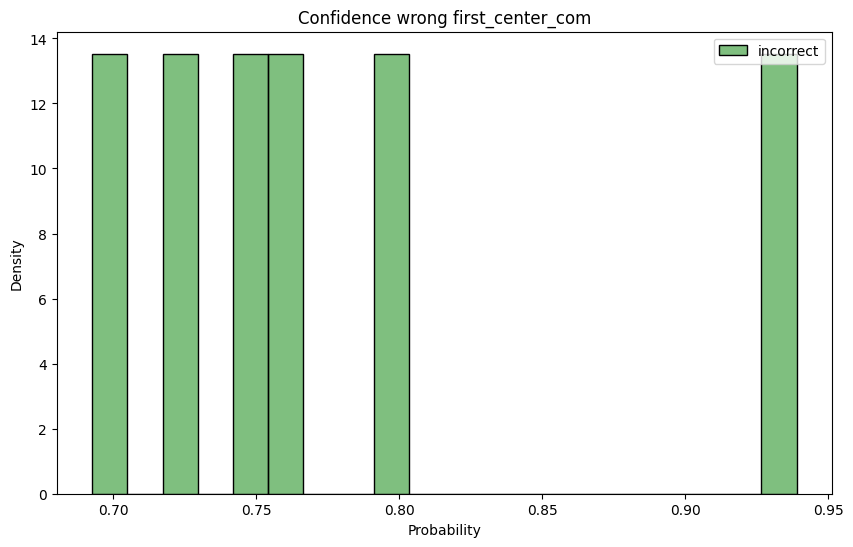

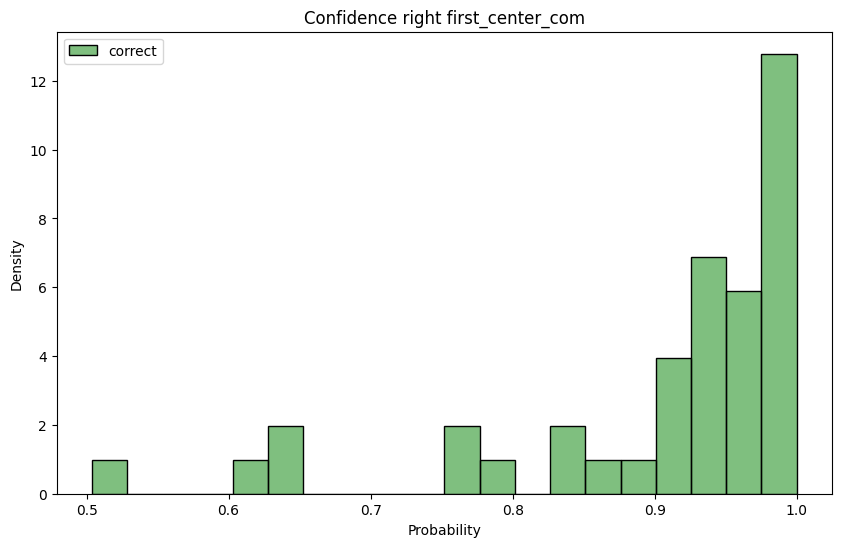

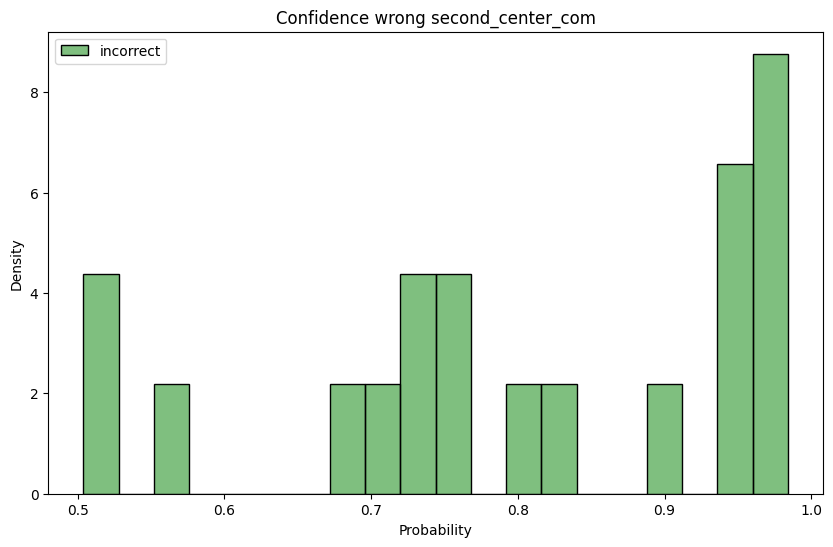

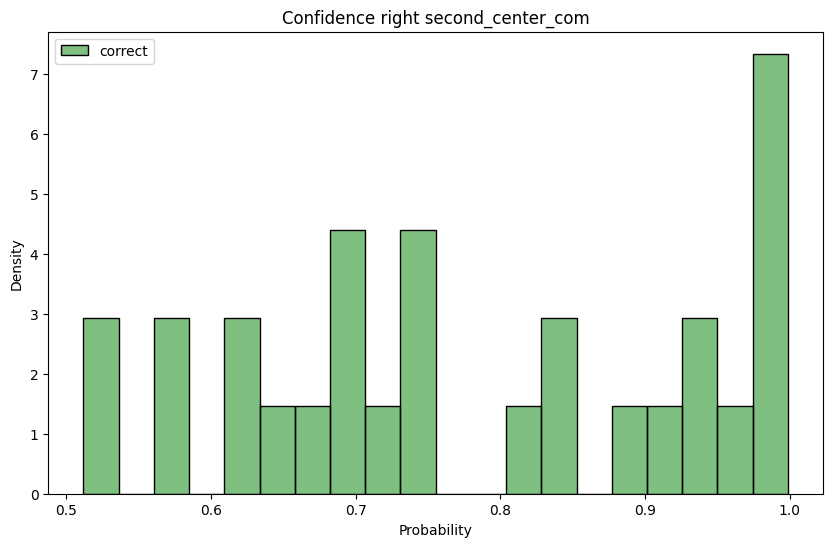

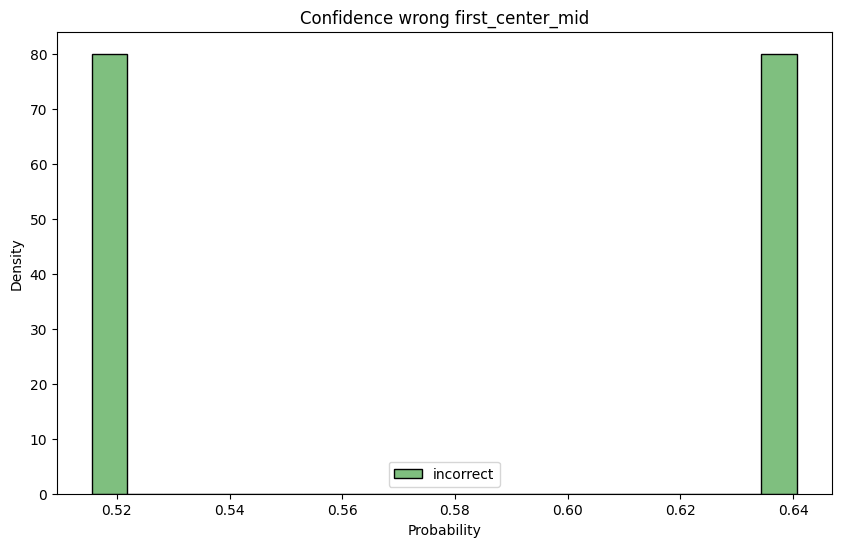

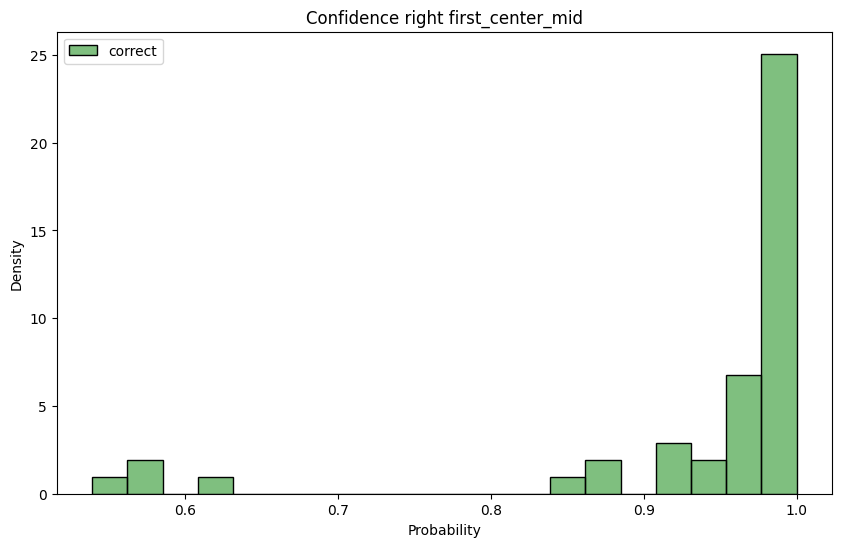

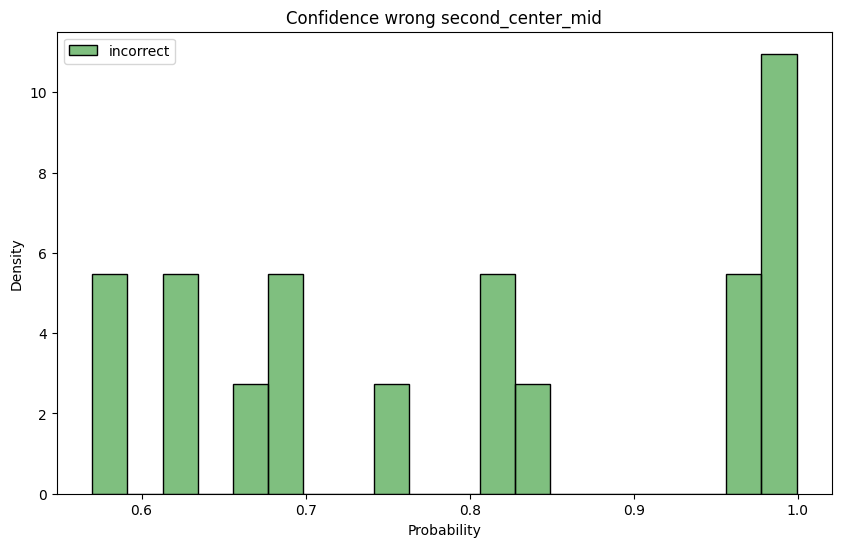

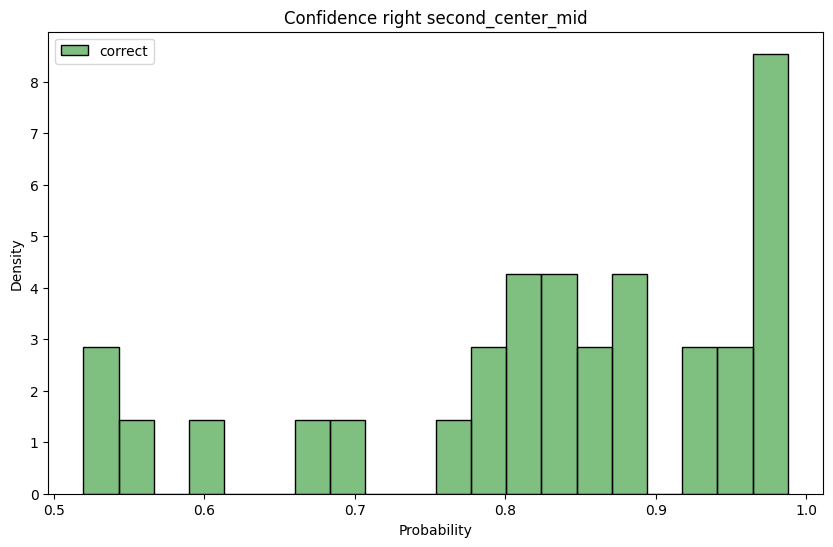

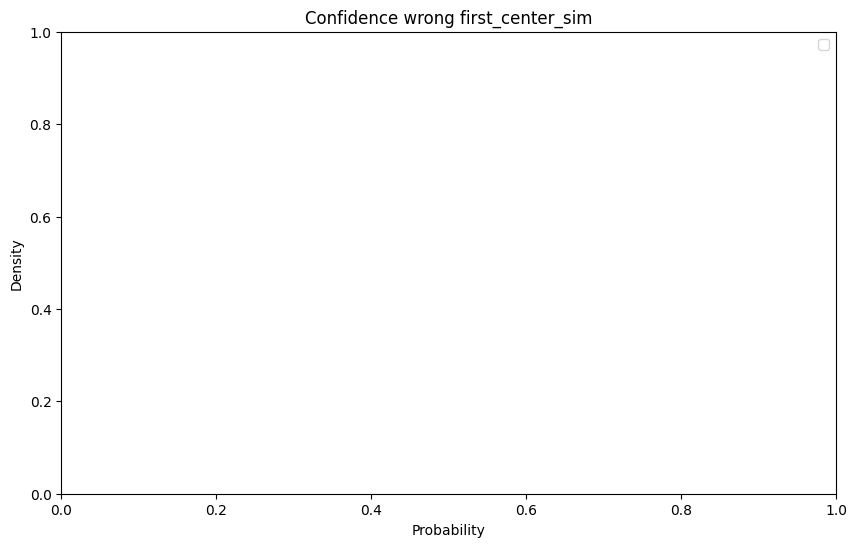

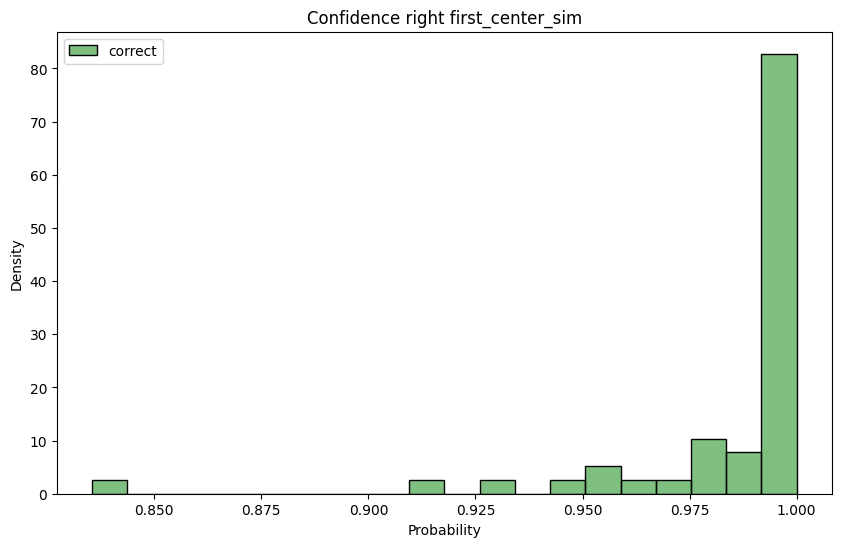

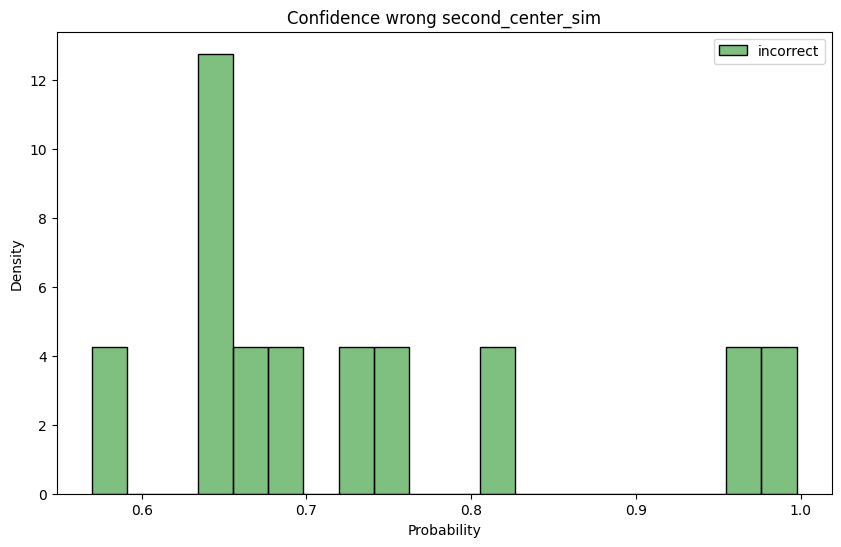

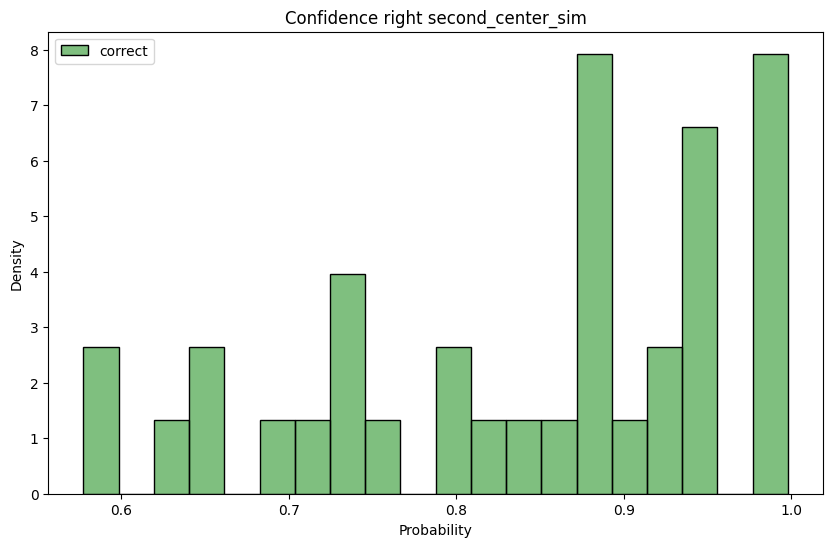

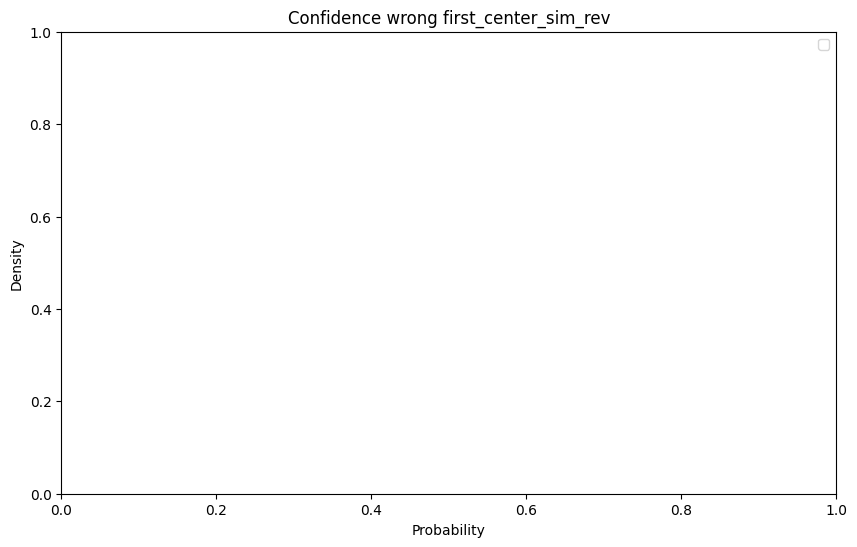

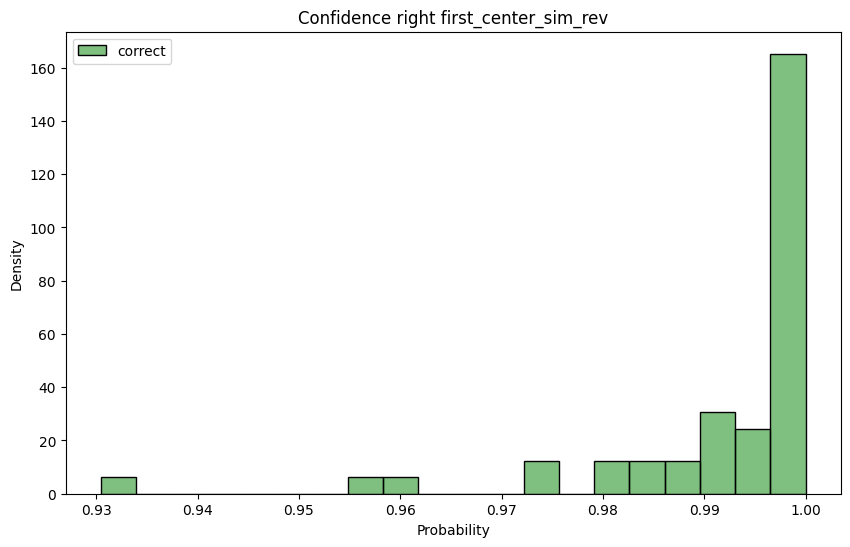

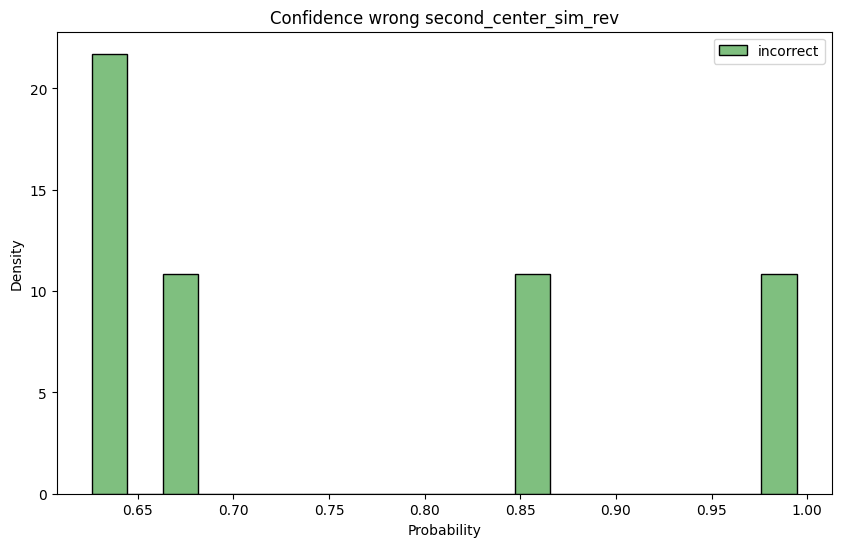

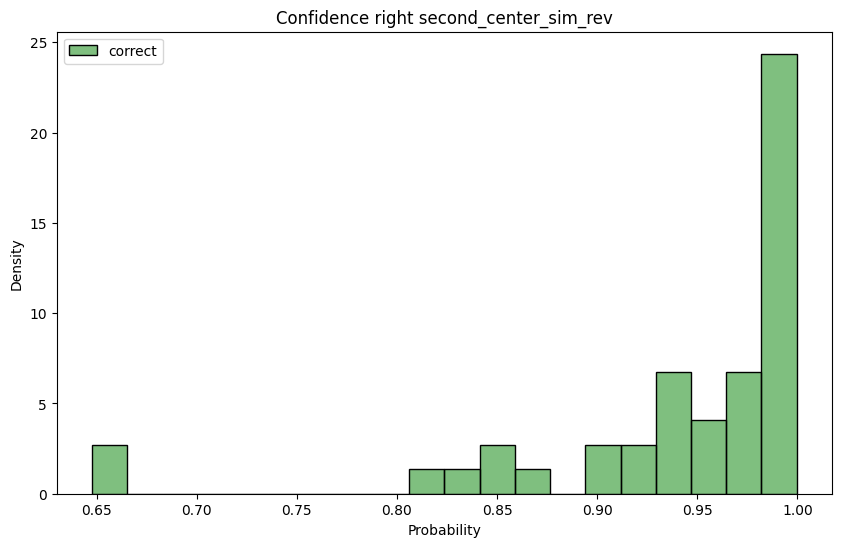

In [156]:
plot_confidence(df[df["type"] == "first_center_com"], "first_center_com", res_dir)
plot_confidence(df[df["type"] == "second_center_com"], "second_center_com", res_dir)
plot_confidence(df[df["type"] == "first_center_mid"], "first_center_mid", res_dir)
plot_confidence(df[df["type"] == "second_center_mid"], "second_center_mid", res_dir)
plot_confidence(df[df["type"] == "first_center_sim"], "first_center_sim", res_dir)
plot_confidence(df[df["type"] == "second_center_sim"], "second_center_sim", res_dir)
plot_confidence(df[df["type"] == "first_center_sim_rev"], "first_center_sim_rev", res_dir)
plot_confidence(df[df["type"] == "second_center_sim_rev"], "second_center_sim_rev", res_dir)

In [157]:
def plot_confidence_grid(df, res_dir):
    # Define the types and grid size
    types = [
        "first_center_com", "second_center_com",
        "first_center_mid", "second_center_mid",
        "first_center_sim", "second_center_sim",
        "first_center_sim_rev", "second_center_sim_rev"
    ]

    # Create a grid of 4 rows and 4 columns (since we have 8 types, each with 2 plots)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.tight_layout(pad=5.0)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, t in enumerate(types):
        # For wrong answers
        wrong = df[(df["type"] == t) & (df["is_correct_prediction"] == False)]
        median_wrong = wrong["incorrect_probability"].median()  # Calculate median for wrong
        sns.histplot(wrong["incorrect_probability"], bins=20, binwidth=0.025, kde=False, color='blue', alpha=0.5, label='incorrect', stat="percent", ax=axes[i*2])
        axes[i*2].axvline(median_wrong, color='red', linestyle='--', linewidth=2)  # Add vertical line at median
        axes[i*2].text(median_wrong, 90, f'{median_wrong:.2f}', color='red', fontsize=10, va='center', ha='right', backgroundcolor='white')  # Add median value text
        axes[i*2].set_title(f'Confidence wrong {t}')
        axes[i*2].set_xlabel('Probability')
        axes[i*2].set_ylabel('Percent')
        axes[i*2].set_xlim(0, 1)
        axes[i*2].set_ylim(0, 100)

        # For correct answers
        right = df[(df["type"] == t) & (df["is_correct_prediction"] == True)]
        median_right = right["correct_probability"].median()  # Calculate median for correct
        sns.histplot(right["correct_probability"], bins=20, binwidth=0.025, kde=False, color='green', alpha=0.5, label='correct', stat="percent", ax=axes[i*2+1])
        axes[i*2+1].axvline(median_right, color='red', linestyle='--', linewidth=2)  # Add vertical line at median
        axes[i*2+1].text(median_right, 90, f'{median_right:.2f}', color='red', fontsize=10, va='center', ha='right', backgroundcolor='white')  # Add median value text
        axes[i*2+1].set_title(f'Confidence right {t}')
        axes[i*2+1].set_xlabel('Probability')
        axes[i*2+1].set_ylabel('Percent')
        axes[i*2+1].set_xlim(0, 1)
        axes[i*2+1].set_ylim(0, 100)

    # Save the entire grid plot
    filename = 'confidence_grid.png'
    file_path = os.path.join(res_dir, filename)
    plt.savefig(file_path)
    plt.show()

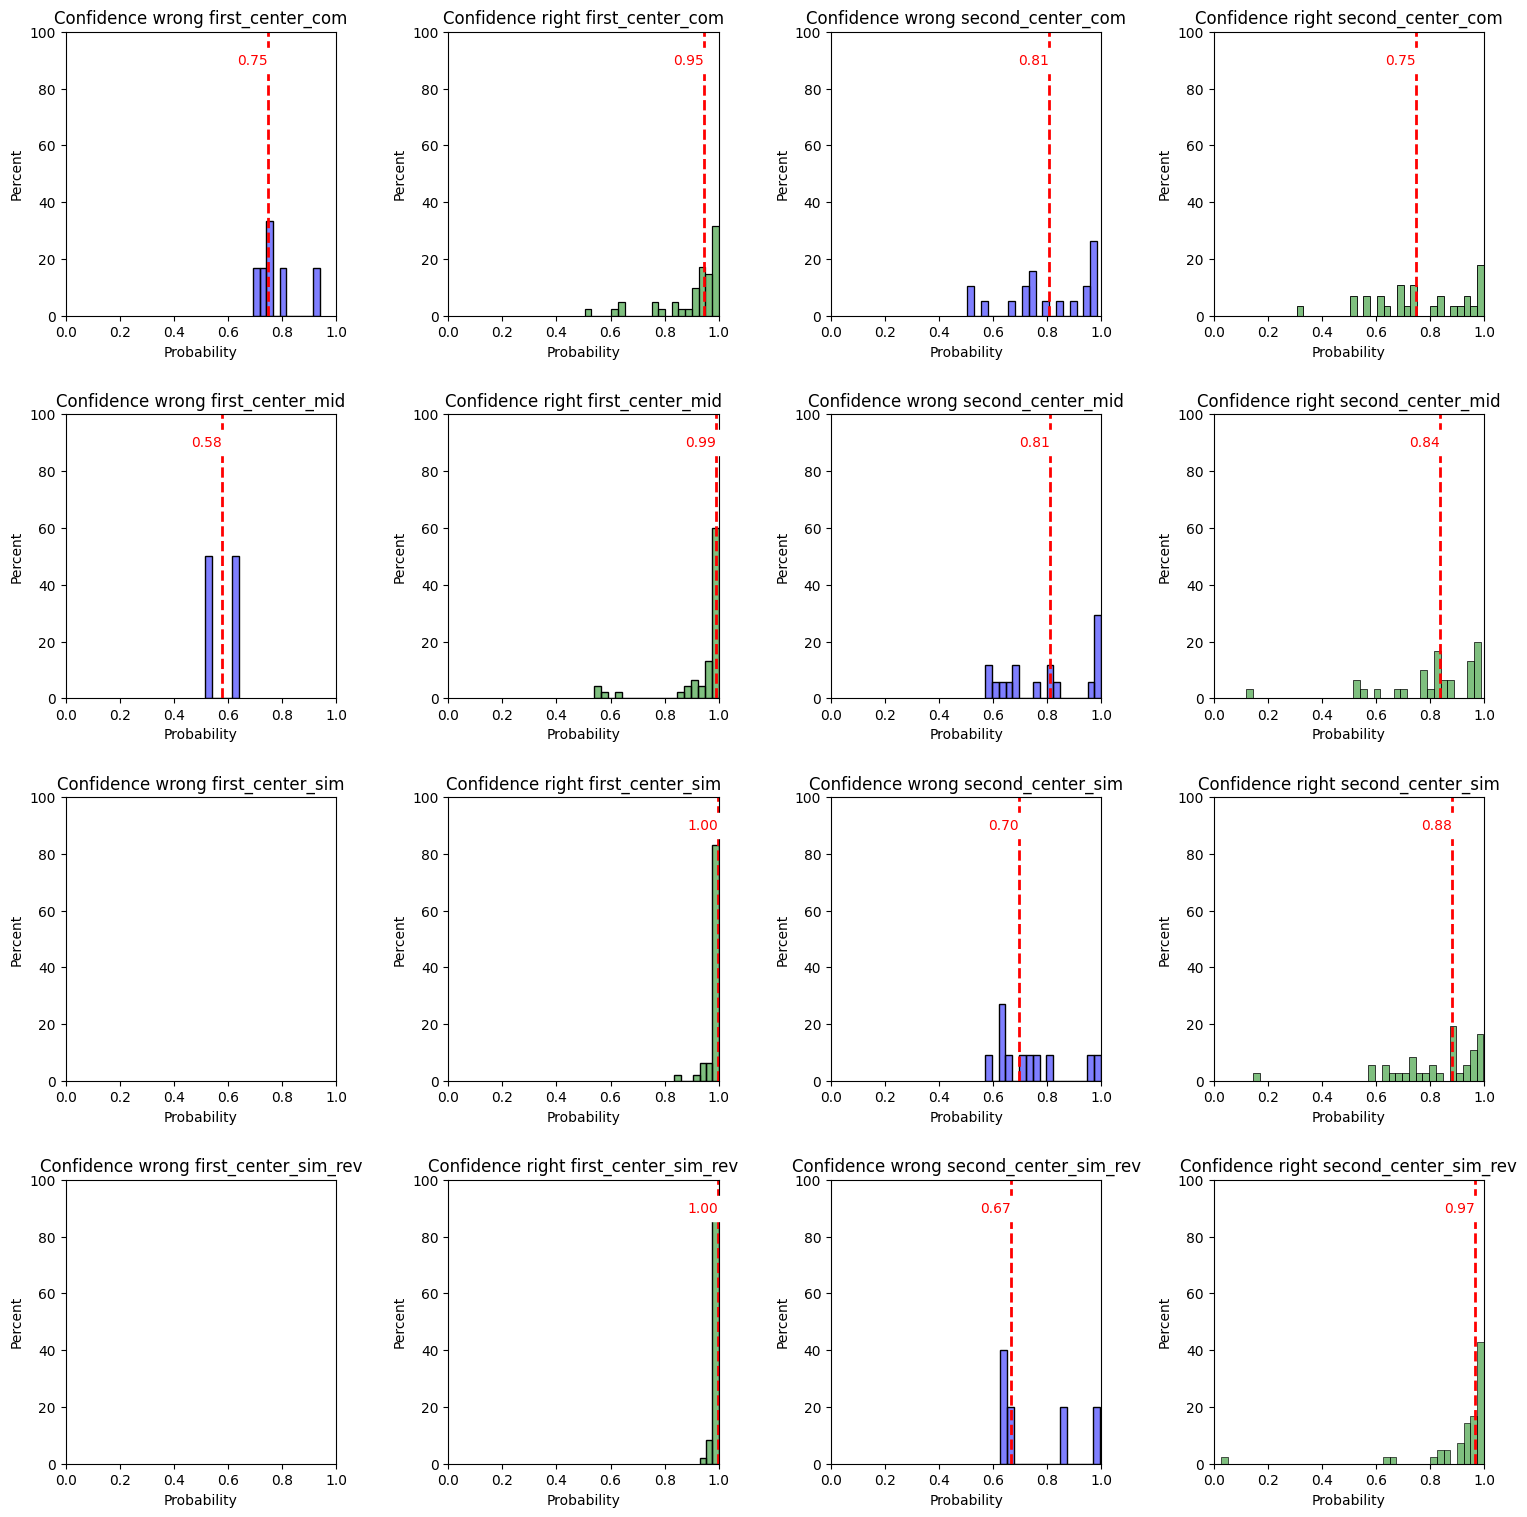

In [54]:
plot_confidence_grid(df, res_dir)

### Compare confidence on com vs the other wordings

In [158]:
def plot_confidence_grid_com_vs_non_com(df, res_dir):
    # Define the types and grid size
    types = [
        "first_center_com", "second_center_com",
        "first_center_mid", "second_center_mid",
        "first_center_sim", "second_center_sim",
        "first_center_sim_rev", "second_center_sim_rev"
    ]

    # Create a grid of 4 rows and 4 columns (since we have 8 types, each with 2 plots)
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    fig.tight_layout(pad=5.0)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, t in enumerate(["first_center_com", "first_center_non_com", "second_center_com", "second_center_non_com"]):
        # For wrong answers
        if t == "first_center_com":
          wrong = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]
        elif t == "first_center_non_com":
          wrong = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == False)]
        elif t == "second_center_com":
          wrong = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]
        else:
          assert(t == "second_center_non_com")
          wrong = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == False)]
        median_wrong = wrong["incorrect_probability"].median()  # Calculate median for wrong
        sns.histplot(wrong["incorrect_probability"], bins=20, binwidth=0.025, kde=False, color='blue', alpha=0.5, label='incorrect', stat="percent", ax=axes[i*2])
        axes[i*2].axvline(median_wrong, color='red', linestyle='--', linewidth=2)  # Add vertical line at median
        axes[i*2].text(median_wrong, 90, f'{median_wrong:.2f}', color='red', fontsize=10, va='center', ha='right', backgroundcolor='white')  # Add median value text
        axes[i*2].set_title(f'Confidence wrong {t}')
        axes[i*2].set_xlabel('Probability')
        axes[i*2].set_ylabel('Percent')
        axes[i*2].set_xlim(0, 1)
        axes[i*2].set_ylim(0, 100)

        # For correct answers
        if t == "first_center_com":
          right = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]
        elif t == "first_center_non_com":
          right = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == True)]
        elif t == "second_center_com":
          right = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]
        else:
          assert(t == "second_center_non_com")
          right = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == True)]
        median_right = right["correct_probability"].median()  # Calculate median for correct
        sns.histplot(right["correct_probability"], bins=20, binwidth=0.025, kde=False, color='green', alpha=0.5, label='correct', stat="percent", ax=axes[i*2+1])
        axes[i*2+1].axvline(median_right, color='red', linestyle='--', linewidth=2)  # Add vertical line at median
        axes[i*2+1].text(median_right, 90, f'{median_right:.2f}', color='red', fontsize=10, va='center', ha='right', backgroundcolor='white')  # Add median value text
        axes[i*2+1].set_title(f'Confidence right {t}')
        axes[i*2+1].set_xlabel('Probability')
        axes[i*2+1].set_ylabel('Percent')
        axes[i*2+1].set_xlim(0, 1)
        axes[i*2+1].set_ylim(0, 100)

    # Save the entire grid plot
    filename = 'confidence_grid.png'
    file_path = os.path.join(res_dir, filename)
    plt.savefig(file_path)
    plt.show()

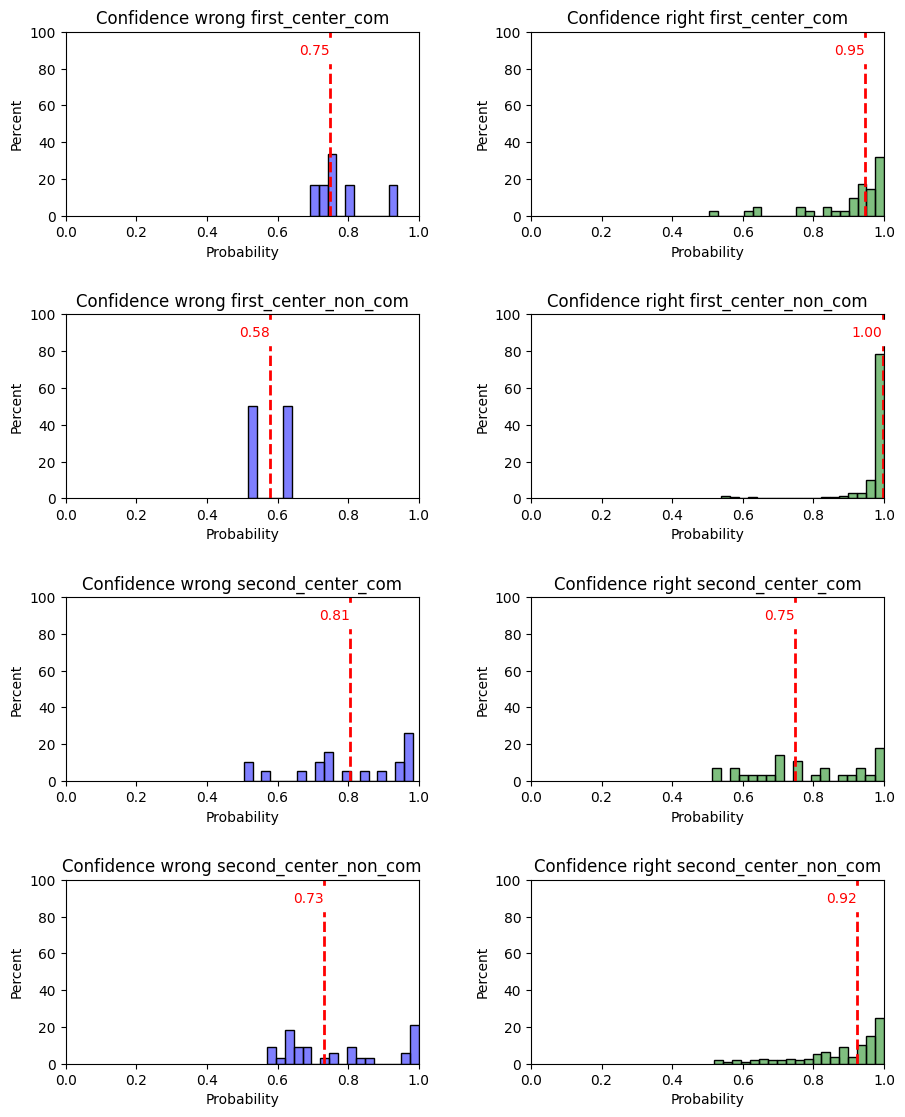

In [159]:
plot_confidence_grid_com_vs_non_com(df, res_dir)

In [160]:
from scipy.stats import mannwhitneyu

# Example data for both distributions (replace with your actual data)
# Assuming you have the two distributions as lists or numpy arrays
for i, t in enumerate(["first_center_right", "first_center_wrong", "second_center_right", "second_center_wrong"]):
    # For wrong answers
    if t == "first_center_right":
      com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
      non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
      alternative = "less"
      hypothesis = "non com has significantly larger values"
    elif t == "first_center_wrong":
      com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
      non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
      alternative = "greater"
      hypothesis = "non com has significantly lower values"
    elif t == "second_center_right":
      com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
      non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
      alternative = "less"
      hypothesis = "non com has significantly larger values"
    else:
      assert(t == "second_center_wrong")
      com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
      non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
      alternative = "greater"
      hypothesis = "non com has significantly lower values"

    # Perform the Mann-Whitney U Test
    stat, p_value = mannwhitneyu(com, non_com, alternative=alternative)

    # Print the results
    print(t.replace("_", " "))
    print(f"U-statistic: {stat}")
    print(f"P-value: {p_value}")


    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis: {hypothesis}.")
    else:
        print("Fail to reject the null hypothesis: No significant difference.")

    print()

    # Optional: Visualize the data
    #plt.hist(com, bins=20, alpha=0.5, label='com')
    #plt.hist(non_com, bins=20, alpha=0.5, label='non_com')
    #plt.legend(loc='upper right')
    #plt.xlabel('Probability')
    #plt.ylabel('Count')
    #plt.title('Distributions Comparison')
    #plt.show()


first center right
U-statistic: 1203.0
P-value: 9.870724824075617e-09
Reject the null hypothesis: non com has significantly larger values.

first center wrong
U-statistic: 12.0
P-value: 0.03571428571428571
Reject the null hypothesis: non com has significantly lower values.

second center right
U-statistic: 947.0
P-value: 0.0011900946808645358
Reject the null hypothesis: non com has significantly larger values.

second center wrong
U-statistic: 339.5
P-value: 0.3139750021334083
Fail to reject the null hypothesis: No significant difference.



In [161]:
# Compare with second center com type - find percentage of right in both out of right in com
# Pivot the DataFrame to have a separate column for each type
pivot_df = df.pivot(index='set_id', columns='type', values='is_correct_prediction')
ids_right_both = pivot_df[(pivot_df["second_center_com"] == True) & (pivot_df["second_center_sim"] == True)].index
ids_right_second_com = pivot_df[(pivot_df["second_center_com"] == True)].index

right_sim_out_of_com = len(ids_right_both) / len(ids_right_second_com)
print(f"Percentage of right in both out of right in com {right_sim_out_of_com}")
print(f"len right second com: {len(ids_right_second_com)}")


Percentage of right in both out of right in com 0.7857142857142857
len right second com: 28


In [162]:
pivot_df

type,first_center_com,first_center_mid,first_center_sim,first_center_sim_rev,second_center_com,second_center_mid,second_center_sim,second_center_sim_rev
set_id,,,,,,,,
1,True,True,True,True,False,False,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,False,True
4,True,True,True,True,True,True,False,True
5,True,True,True,True,False,False,True,True
6,True,True,True,True,True,False,True,False
7,True,True,True,True,True,False,True,True
8,False,True,True,True,True,True,True,True
10,True,True,True,True,True,True,False,True


In [163]:
# Finds ids where right in com but wrong in sim
ids_weird = pivot_df[(pivot_df["second_center_com"] == True) & (pivot_df["second_center_sim"] == False)].index

In [164]:
second_center_right_com_wrong_sim = df[(df["set_id"].isin(ids_weird)) & (df["type"].isin(["second_center_sim", "second_center_com"]))]

In [165]:
out_path = os.path.join(res_dir, "second_center_right_com_wrong_sim.csv")
second_center_right_com_wrong_sim.to_csv(out_path, index=False)